In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.9/321.9 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 464.1/464.1 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.27.1
    Uninstalling huggingface-hub-0.27.1:
      Successfully uninstalled huggingface-hub-0.27.1


In [ ]:
import os
import cv2
import numpy as np
import shutil
import glob
import json
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:

# Define paths
base_path = "/content/drive/My Drive/UareU_sample_DB"
train_folder = "/content/drive/My Drive/UareU_train"
unknown_folder = os.path.join(train_folder, "Unknown")
processed_folder = "/content/drive/My Drive/UareU_processed"

# Ensure required directories exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(unknown_folder, exist_ok=True)
os.makedirs(processed_folder, exist_ok=True)

# Extract class labels (persons)
files = [f for f in os.listdir(base_path) if f.endswith((".tif", ".jpg", ".png"))]
print(f"Total images found: {len(files)}")

person_classes = sorted(set([file.split('_')[0] for file in files]))  # Extract unique person IDs
name_mapping = {person_id: f"Person_{i}" for i, person_id in enumerate(person_classes)}

# Save name mapping
with open("/content/drive/My Drive/name_mapping.json", "w") as f:
    json.dump(name_mapping, f)
print("Name mapping saved.")

# Convert all images to PNG and store in processed folder
def convert_to_png(image_path, save_folder):
    """Convert all image formats to PNG and save in the specified folder."""
    img = Image.open(image_path)
    img = img.convert("RGB")  # Convert to RGB for compatibility
    new_name = os.path.splitext(os.path.basename(image_path))[0] + ".png"
    new_path = os.path.join(save_folder, new_name)

    if not os.path.exists(new_path):  # Avoid overwriting existing files
        img.save(new_path, "PNG")

    return new_path

# Process and store images
for file_name in files:
    file_path = os.path.join(base_path, file_name)
    new_path = convert_to_png(file_path, processed_folder)

    person_id = file_name.split('_')[0]
    class_name = name_mapping[person_id]
    class_folder = os.path.join(train_folder, class_name)
    os.makedirs(class_folder, exist_ok=True)

    dest_path = os.path.join(class_folder, os.path.basename(new_path))
    if not os.path.exists(dest_path):  # Avoid duplicate copies
        shutil.copy(new_path, dest_path)

# Ensure Unknown folder is processed
unknown_files = glob.glob(os.path.join(unknown_folder, "*.*"))
for unknown_file in unknown_files:
    convert_to_png(unknown_file, unknown_folder)

print("All images have been processed and stored in train directories.")

# Define ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(128, 128),
    color_mode='grayscale',
    batch_size=16,
    class_mode='sparse',
    shuffle=True
)


Total images found: 520
Name mapping saved.


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


All images have been processed and stored in train directories.
Found 701 images belonging to 8 classes.


In [ ]:

# Define CNN model
model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(128, 128, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(512, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(len(person_classes) + 1, activation='softmax')  # +1 for Unknown class
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(train_generator, epochs=50)

# Save trained model
model.save("/content/drive/My Drive/fingerprint_model_with_unknown.h5")
print("Model with Unknown class saved successfully!")


Mounted at /content/drive
Total images found: 520
Name mapping saved.


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


All images have been processed and stored in train directories.
Found 700 images belonging to 8 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.4189 - loss: 6.7604
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - accuracy: 0.7120 - loss: 1.4746
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.7886 - loss: 0.7355
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.8865 - loss: 0.4287
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.8510 - loss: 0.7093
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9203 - loss: 0.2907
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.9026 - loss: 0.3252
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 126s 3s/step - accuracy: 0.9740 - loss: 0.1009
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.9690 - loss: 0.1199
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 125s 3s/step - accuracy: 0.9576 - loss: 0.1049
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - accuracy: 0.9526 - loss: 0.1639
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy:

Model with Unknown class saved successfully!


In [ ]:
import os
import numpy as np
import json
import cv2
from PIL import Image

# Dataset and database paths
dataset_path = "/content/drive/My Drive/UareU_sample_DB"
database_path = "/content/drive/My Drive/fingerprint_features.json"

# Hamming threshold for identification (Lower = More sensitivity to unknown)
HAMMING_THRESHOLD = 0.3

# Convert an image to a binary representation based on pixel intensity
def convert_image_to_binary(image_path):
    """Convert an image to a binary representation (black = 1, white = -1)."""
    image = Image.open(image_path).convert("L")  # Convert to grayscale
    width, height = image.size
    pixels = image.load()
    binary_representation = []

    for i in range(width):
        for j in range(height):
            intensity = pixels[i, j]  # Grayscale intensity
            binary_representation.append(1 if intensity < 128 else -1)  # Black = 1, White = -1

    return binary_representation

# Extract features from all images and save to the database
fingerprint_database = {}
files = [f for f in os.listdir(dataset_path) if f.endswith(('.tif', '.jpg', '.png'))]

for file_name in files:
    file_path = os.path.join(dataset_path, file_name)
    binary_pattern = convert_image_to_binary(file_path)
    fingerprint_database[file_name] = binary_pattern

# Save feature database
with open(database_path, "w") as f:
    json.dump(fingerprint_database, f)

print("✅ Feature database saved successfully!")

# Hamming Neural Network class
class HammingNN:
    def __init__(self, database):
        """Initialize the Hamming Neural Network with a feature database."""
        self.database = {name: np.array(features) for name, features in database.items()}

    def hamming_distance(self, a, b):
        """Calculate the normalized Hamming distance between two binary patterns."""
        return np.sum(a != b) / len(a)

    def predict(self, input_pattern):
        """Predict the closest match for an input fingerprint."""
        input_pattern = np.array(input_pattern)
        scores = {name: self.hamming_distance(input_pattern, pattern) for name, pattern in self.database.items()}
        best_match = min(scores, key=scores.get)  # Find the lowest distance

        # If the best match exceeds the threshold, return "Unknown"
        if scores[best_match] > HAMMING_THRESHOLD:
            return "Unknown"
        return best_match

# Load the fingerprint feature database
with open(database_path, "r") as f:
    fingerprint_database = json.load(f)

# Initialize the Hamming Neural Network
hamming_nn = HammingNN(fingerprint_database)

# Test the model on the full dataset
correct_predictions = 0
total_tests = len(files)

print("\n🔍 **Testing Hamming NN on the Full Dataset**")
for test_file in files:
    test_path = os.path.join(dataset_path, test_file)

    # Convert test image to binary format
    test_pattern = convert_image_to_binary(test_path)

    # Predict the closest match
    predicted_name = hamming_nn.predict(test_pattern)

    # Extract the actual person ID from filename
    actual_name = test_file.split('_')[0]

    # Compare prediction with ground truth
    if predicted_name.startswith(actual_name):
        correct_predictions += 1

    print(f"🔍 Test Image: {test_file} → Predicted: {predicted_name}")

# Compute accuracy
accuracy = (correct_predictions / total_tests) * 100

print(f"\n📊 **Final Results:**")
print(f"✅ Hamming NN Accuracy: {accuracy:.2f}%")

✅ Feature database saved successfully!

🔍 **Testing Hamming NN on the Full Dataset**
🔍 Test Image: 012_1_6.tif → Predicted: 012_1_6.tif
🔍 Test Image: 012_10_6.tif → Predicted: 012_10_6.tif
🔍 Test Image: 012_2_7.tif → Predicted: 012_2_7.tif
🔍 Test Image: 012_10_7.tif → Predicted: 012_10_7.tif
🔍 Test Image: 012_1_3.tif → Predicted: 012_1_3.tif
🔍 Test Image: 012_2_8.tif → Predicted: 012_2_8.tif
🔍 Test Image: 012_1_1.tif → Predicted: 012_1_1.tif
🔍 Test Image: 012_3_4.tif → Predicted: 012_3_4.tif
🔍 Test Image: 012_10_4.tif → Predicted: 012_10_4.tif
🔍 Test Image: 012_1_8.tif → Predicted: 012_1_8.tif
🔍 Test Image: 012_2_5.tif → Predicted: 012_2_5.tif
🔍 Test Image: 012_10_8.tif → Predicted: 012_10_8.tif
🔍 Test Image: 012_2_1.tif → Predicted: 012_2_1.tif
🔍 Test Image: 012_2_6.tif → Predicted: 012_2_6.tif
🔍 Test Image: 012_2_2.tif → Predicted: 012_2_2.tif
🔍 Test Image: 012_3_2.tif → Predicted: 012_3_2.tif
🔍 Test Image: 012_1_5.tif → Predicted: 012_1_5.tif
🔍 Test Image: 012_10_2.tif → Predicted: 

✅ CNN Model Loaded Successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━

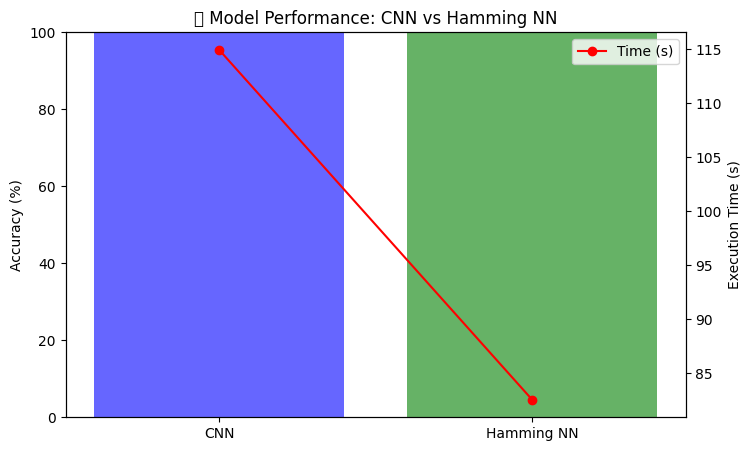

In [ ]:
import os
import time
import numpy as np
import json
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Paths
dataset_path = "/content/drive/My Drive/UareU_sample_DB"
cnn_model_path = "/content/drive/My Drive/fingerprint_model_with_unknown.h5"
hamming_db_path = "/content/drive/My Drive/fingerprint_features.json"

# Load CNN model
model = load_model(cnn_model_path)
print("✅ CNN Model Loaded Successfully!")

# Class mapping
name_mapping = {
    "012": "Person_0",
    "013": "Person_1",
    "017": "Person_2",
    "022": "Person_3",
    "027": "Person_4",
    "057": "Person_5",
    "076": "Person_6"
}

# Load Hamming NN feature database
with open(hamming_db_path, "r") as f:
    fingerprint_database = json.load(f)

# Hamming NN Class
class HammingNN:
    def __init__(self, database):
        self.database = {k: np.array(v) for k, v in database.items()}

    def hamming_distance(self, a, b):
        return np.sum(a != b) / len(a)  # Normalized Hamming distance

    def predict(self, input_pattern):
        input_pattern = np.array(input_pattern)
        scores = {name: self.hamming_distance(input_pattern, pattern) for name, pattern in self.database.items()}
        best_match = min(scores, key=scores.get)  # Find lowest distance
        return best_match  # Return filename of the match

# Initialize Hamming NN model
hamming_nn = HammingNN(fingerprint_database)

# Convert images to binary representation for Hamming NN
def convert_image_to_binary(path):
    image = Image.open(path).convert("L")  # Convert to grayscale
    pix = image.load()
    width, height = image.size
    binary_representation = []
    for i in range(width):
        for j in range(height):
            binary_representation.append(1 if pix[i, j] < 128 else -1)  # Black = 1, White = -1
    return binary_representation

# Preprocess images for CNN
def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128)) / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    return img

# Extract person ID from filename for Hamming NN mapping
def extract_person_id(filename):
    person_id = filename.split('_')[0]  # Extract first part of filename
    return name_mapping.get(person_id, "Unknown")  # Convert to Person_X format

# Get list of test images
test_images = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith(('.tif', '.jpg', '.png'))]

# Accuracy counters
correct_cnn = 0
correct_hamming = 0
total_tests = len(test_images)

# Timing
cnn_start_time = time.time()
for test_path in test_images:
    # CNN Prediction
    processed_img = preprocess_image(test_path)
    prediction = model.predict(processed_img)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    # Convert CNN class to Person_X format
    predicted_name_cnn = f"Person_{predicted_class}" if predicted_class in range(len(name_mapping)) else "Unknown"

    # Compare with actual label
    actual_name = extract_person_id(os.path.basename(test_path))
    correct_cnn += 1 if predicted_name_cnn == actual_name else 0

cnn_end_time = time.time()
cnn_time = cnn_end_time - cnn_start_time

# Timing for Hamming NN
hamming_start_time = time.time()
for test_path in test_images:
    # Hamming NN Prediction
    test_pattern = convert_image_to_binary(test_path)
    predicted_file_hamming = hamming_nn.predict(test_pattern)
    predicted_name_hamming = extract_person_id(predicted_file_hamming)  # Convert to Person_X

    # Compare with actual label
    actual_name = extract_person_id(os.path.basename(test_path))
    correct_hamming += 1 if predicted_name_hamming == actual_name else 0

hamming_end_time = time.time()
hamming_time = hamming_end_time - hamming_start_time

# Calculate accuracies
accuracy_cnn = (correct_cnn / total_tests) * 100
accuracy_hamming = (correct_hamming / total_tests) * 100

# Print final results
print("\n📊 **Final Results:**")
print(f"✅ CNN Accuracy: {accuracy_cnn:.2f}% (Time: {cnn_time:.2f}s)")
print(f"✅ Hamming NN Accuracy: {accuracy_hamming:.2f}% (Time: {hamming_time:.2f}s)")

# Plot comparison chart
models = ["CNN", "Hamming NN"]
accuracies = [accuracy_cnn, accuracy_hamming]
times = [cnn_time, hamming_time]

fig, ax1 = plt.subplots(figsize=(8, 5))

# Accuracy plot
ax1.bar(models, accuracies, color=['blue', 'green'], alpha=0.6, label="Accuracy (%)")
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim(0, 100)

# Time plot
ax2 = ax1.twinx()
ax2.plot(models, times, color='red', marker='o', label="Time (s)")
ax2.set_ylabel("Execution Time (s)")

plt.title("🔍 Model Performance: CNN vs Hamming NN")
plt.legend()
plt.show()

In [ ]:
import gradio as gr
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import json
from PIL import Image

# Set Confidence threshold
CONFIDENCE_THRESHOLD = 0.8

# Load the trained CNN model
cnn_model = load_model("/content/drive/My Drive/fingerprint_model_with_unknown.h5")
print("✅ CNN Model loaded successfully!")

# Load class name mapping
with open("/content/drive/My Drive/name_mapping_fixed.json", "r") as f:
    name_mapping = json.load(f)

# Get the index for the "Unknown" class (last class)
unknown_class_index = len(name_mapping) - 1

# Preprocessing function for CNN
def preprocess_image(img):
    img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    img = cv2.resize(img, (128, 128)) / 255.0  # Resize and normalize
    img = np.expand_dims(img, axis=-1)  # Add a color channel dimension
    img = np.expand_dims(img, axis=0)  # Add a batch dimension
    return img

# CNN Prediction function
def predict_with_cnn(img):
    processed_img = preprocess_image(img)
    prediction = cnn_model.predict(processed_img)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)

    if predicted_class == unknown_class_index or confidence < CONFIDENCE_THRESHOLD:
        return f"❌ Unknown Fingerprint (Confidence: {confidence:.2f})"
    else:
        predicted_name = name_mapping.get(str(predicted_class), "Unknown")
        return f"✅ Identified as: {predicted_name} (Confidence: {confidence:.2f})"


# Hamming NN Prediction setup
HAMMING_THRESHOLD = 0.3  # Threshold for unknown detection

# Function to convert an image to binary (Hamming)
def convert_image_to_binary(path):
    image = Image.open(path)
    if image.mode != "L":
        image = image.convert("RGB")
    pix = image.load()
    width, height = image.size
    binary_representation = []

    for i in range(width):
        for j in range(height):
            intensity = sum(pix[i, j])  # Sum of RGB values
            binary_representation.append(1 if intensity < 128 else -1)

    return binary_representation

# Hamming NN class
class HammingNN:
    def __init__(self, database):
        self.database = {k: np.array(v) for k, v in database.items()}

    def hamming_distance(self, a, b):
        return np.sum(a != b) / len(a)  # Normalized Hamming distance

    def predict(self, input_pattern):
        input_pattern = np.array(input_pattern)
        scores = {name: self.hamming_distance(input_pattern, pattern) for name, pattern in self.database.items()}
        best_match = min(scores, key=scores.get)  # Find the best match
        if scores[best_match] > HAMMING_THRESHOLD:
            return "Unknown", scores[best_match]
        return best_match, scores[best_match]

# Load Hamming NN database
with open("/content/drive/My Drive/fingerprint_features.json", "r") as f:
    fingerprint_database = json.load(f)

hamming_nn = HammingNN(fingerprint_database)

# Hamming NN prediction function
def predict_with_hamming(img):
    img_path = "/content/temp_img.jpg"
    img.save(img_path)  # Save the image temporarily to run through the Hamming NN
    test_pattern = convert_image_to_binary(img_path)
    predicted_name, confidence = hamming_nn.predict(test_pattern)
    return f"🔍 Predicted Name: {predicted_name} (Distance: {confidence:.2f})"


# Gradio interface function
def predict_fingerprint(img, model_choice):
    if model_choice == 'CNN':
        return predict_with_cnn(img)
    else:
        return predict_with_hamming(img)


# Gradio UI with model selection
iface = gr.Interface(
    fn=predict_fingerprint,
    inputs=[
        gr.Image(type="pil", label="Upload Fingerprint Image"),
        gr.Dropdown(
            choices=['CNN', 'Hamming NN'],
            label="Choose Model",
            value='CNN'  # Default to CNN
        )
    ],
    outputs="text",
    title="🔍 Fingerprint Recognition",
    description="""
    🏆 **Upload a fingerprint image to identify the person.**
    - ✅ Select between **CNN** or **Hamming NN** to identify the fingerprint.
    - 🔍 The AI model will return the predicted identity.
    - ❌ If confidence is too low, the fingerprint will be marked as **Unknown**.
    """,
    theme="huggingface",
    live=True
)

# Launch Gradio Interface
iface.launch(share=True)

✅ CNN Model loaded successfully!


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1088: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-67a3eeb3-3699425d0683e05a31e4c79b;20593991-a485-40c8-8ad4-84326e0a3c1b)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1c6d2cf40ed06f7d26.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
